In [1]:
# Imports
import random

import torch
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # for date-time formatting in plotting
import pandas as pd

import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from IPython.display import display
from torch.utils.data import DataLoader, TensorDataset

# Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # Interactive display
%config InlineBackend.figure_format = 'retina'

# For progress bars
from tqdm.notebook import tqdm

#-- Utilizing the specific project modules --#

# Appending our path so we can use our 'src' modules:
import sys
sys.path.append('/Users/johnbuggeln/Desktop/crypto-forecast/src')
import pytorch_helpers as th

# EDA and Viewing our Bitcoin Dataset

In [2]:
# Loading in the bitcoin SV dataset:
PATH = '/Users/johnbuggeln/Desktop/crypto-forecast/'
BITCOIN = pd.read_csv(PATH + 'Top100CryptoCoins/bitcoin.csv')
BITCOIN.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2010-07-18,0.0,0.1,0.1,0.1,75,USD
1,2010-07-19,0.1,0.1,0.1,0.1,574,USD
2,2010-07-20,0.1,0.1,0.1,0.1,262,USD
3,2010-07-21,0.1,0.1,0.1,0.1,575,USD
4,2010-07-22,0.1,0.1,0.1,0.1,2160,USD


index data (e.g. length): RangeIndex(start=0, stop=4420, step=1)


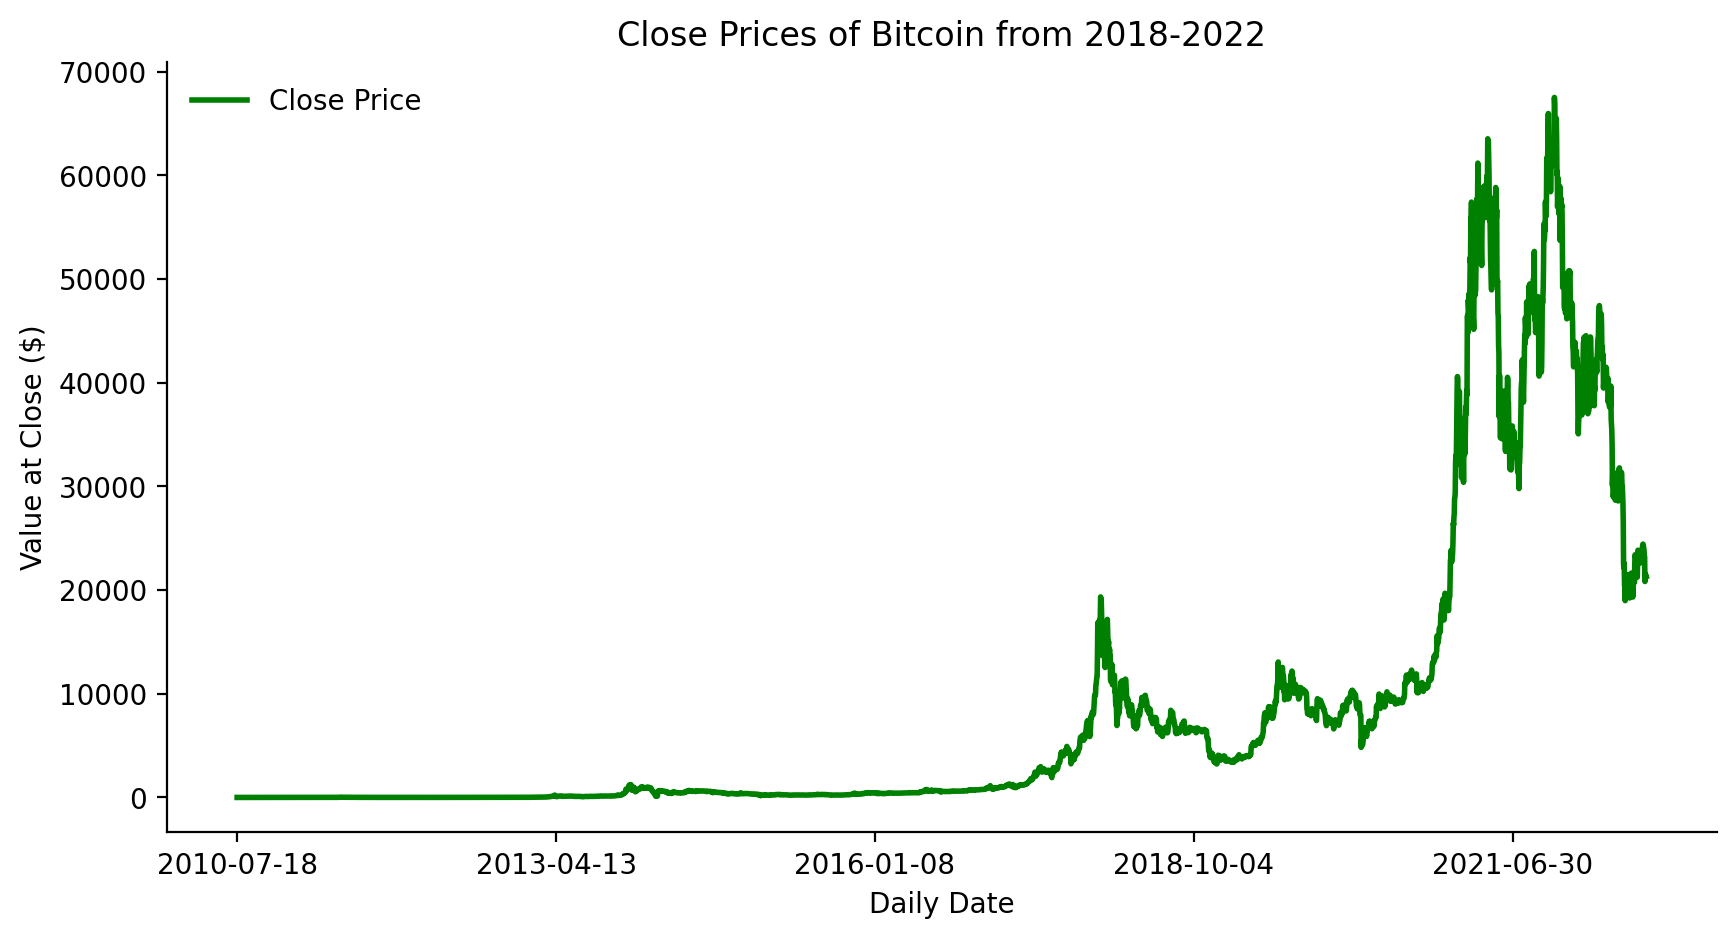

In [3]:
# Quick and Dirty plotting our close dates
fig, ax = plt.subplots(figsize = (10,5))
BITCOIN.plot('Date', 'Close', ax = ax, color = 'green', label = 'Close Price', linewidth = 2.0);
ax.set_ylabel('Value at Close ($)');
ax.set_xlabel('Daily Date');
ax.set_title('Close Prices of Bitcoin from 2018-2022')
ax.legend(frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print("index data (e.g. length):", BITCOIN.index)
plt.savefig(PATH + 'model_images/ClosePrices.png', dpi = 150)

index data (e.g. length): RangeIndex(start=0, stop=4420, step=1)


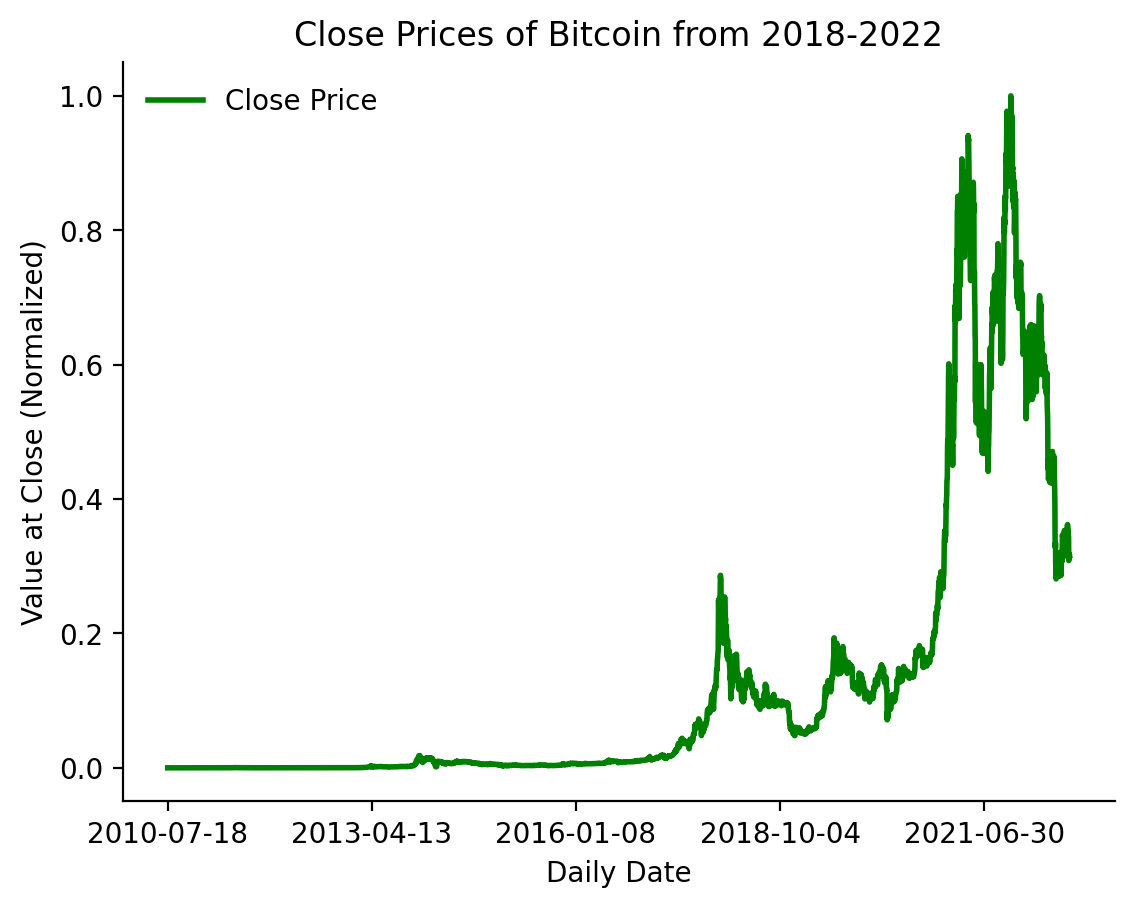

In [4]:
# Normalizing our Data for our Network

scaler = MinMaxScaler()
BITCOIN['scale'] = scaler.fit_transform(BITCOIN['Close'].values.reshape(-1,1))
BITCOIN['scale'].head()

# Quick and Dirty plotting our close dates
fig, ax = plt.subplots()
BITCOIN.plot('Date', 'scale', ax = ax, color = 'green', label = 'Close Price', linewidth = 2.0);
ax.set_ylabel('Value at Close (Normalized)');
ax.set_xlabel('Daily Date');
ax.set_title('Close Prices of Bitcoin from 2018-2022')
ax.legend(frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print("index data (e.g. length):", BITCOIN.index)

In [5]:
# Lagging our time series data, so we can use and MLP for forecasting:
num_lags = 5 # note increasing more time lags will truncate beginning of the data-set
close_prices = BITCOIN['scale']
lag_CLOSEPRICES = pd.DataFrame()
for i in range(num_lags + 1):
    shifted_data = close_prices.shift(i)
    lag_CLOSEPRICES[f"Lag{i}"] = shifted_data

# Adding the date column:
lag_CLOSEPRICES.insert(0, 'Date', BITCOIN['Date'])

# Removing the data points that are missing lags, and resetting our index:
lag_CLOSEPRICES = lag_CLOSEPRICES.dropna(ignore_index = True)
display(lag_CLOSEPRICES.head())

print(lag_CLOSEPRICES['Date'])

,Date,Lag0,Lag1,Lag2,Lag3,Lag4,Lag5
0,2010-07-23,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-07-24,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-07-25,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-07-26,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-07-27,0.0,0.0,0.0,0.0,0.0,0.0


0       2010-07-23
1       2010-07-24
2       2010-07-25
3       2010-07-26
4       2010-07-27
           ...    
4410    2022-08-19
4411    2022-08-20
4412    2022-08-21
4413    2022-08-22
4414    2022-08-23
Name: Date, Length: 4415, dtype: object


# Defining our Model

In [6]:
# Building the network architecture
DEVICE = th.set_device() # will use the 'mps' mac GPU to train on pytorch if available.

# Building our class for our generalizable MLP
class Net(nn.Module):
    """
    Initialize MLP network.
    """
    def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num = 1):
        """Initialize MLP Network class
        
        Args:
            actv: string 
                type of activation function to be used.
            input_feature_num: integer
                number of input features (size of our vector/array). In this case the number of lags in our data.
            hidden_unit_nums: list
                number of units in in each hidden layer of our MLP.
            output_feature_num: integer
                Number of output features. Should be usual 1, given our forecasting problem.
        
        Returns:
            N/A
        """
        
        super().__init__()
        self.input_feature_num = input_feature_num
        self.mlp = nn.Sequential() # convenience object that lets us create a repetitive sequence of neural network architecture.
        
        in_num = input_feature_num
        for i in range(len(hidden_unit_nums)):
            
            out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
            layer = nn.Linear(in_num, out_num) # Use nn.Linear to define the layer in our sequence
            in_num = out_num # Assign next layer input using current layer output
            self.mlp.add_module(f"Linear_{i}", layer) # Append layer to the model with a name
            
            actv_layer = actv # Assign activation function (eval allows us to instantiate object from string)
            self.mlp.add_module(f"Activation_{i}", actv_layer) # Append activation to the model with a name
        
        out_layer = nn.Linear(out_num, output_feature_num)
        self.mlp.add_module('Output Linear', out_layer)

    def forward(self, x):
        """Define forward pass of the MLP.
    
        Args:
          x: torch.tensor
            Input data
    
        Returns:
          logits
        """
        
        # Reshape inputs to (batch_size, input_feature_num)
        x = x.view(-1, self.input_feature_num) # returns the same tensor; and reshapes it w/o using more memory. -1 is wildcard for the number of rows w/ set columns.
        prediction = self.mlp(x)
        return prediction
        
    # Choose the most likely label predicted by the network
    def predict(self, x):
        """
        Performs the prediction task of the network
    
        Args:
          x: torch.Tensor
            Input tensor of size ([3])
    
        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)
    
        # Our best guess forecasting given our current model
        return output


GPU is enabled in this notebook. 



In [7]:
# Our loss function (using MSE):
MSE = nn.MSELoss()
MAE = nn.L1Loss()

play_data = torch.tensor([1,1,1], dtype = torch.float32)
play_pred = torch.tensor([3,3,3])

# Testing
MSE_loss = MSE(play_data, play_pred).item()
print(MSE_loss, "as expected")

4.0 as expected


## Shuffling and splitting our data

In [8]:
# The name of our lagged close prices: lag_CLOSEPRICES. The first column is our 'zero-lagged' price.
# This price is the one we are trying to predict.

# Grabbing our y_data (nb requires_grad defaults to false unless a nn.Parameter object (e.g. weights of nn.Linear):
X = torch.tensor(lag_CLOSEPRICES.iloc[:, 2:num_lags+2].to_numpy(), dtype = torch.float32)
y = torch.tensor(lag_CLOSEPRICES['Lag0'], dtype = torch.float32)

def shuffle_and_split_data(X, y):
  """
  Helper function to shuffle and split incoming data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  # Number of samples
  N = X.shape[0]
  # Shuffle data
  shuffled_indices = torch.randperm(N) # Get indices to shuffle data
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(N*0.2)   # Assign test datset size using 20% of samples
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train, shuffled_indices # put our data into train and test set.

X_test, y_test, X_train, y_train, shuffled_indices = shuffle_and_split_data(X, y)

In [9]:
# Recovering our data indices:
N = X.shape[0]
test_size = int(N*0.2)
dates = lag_CLOSEPRICES['Date'].to_numpy()
dates = dates[shuffled_indices]
train_dates = dates[test_size:]
test_dates = dates[:test_size]

#-- Converting our train_dates to date-time type --#

# Training Set
train_dates = pd.to_datetime(train_dates, format = "ISO8601")
train_DF = pd.DataFrame({"Date": train_dates, "Training Set": y_train})
train_DF = train_DF.sort_values(by='Date', ascending = True)
display(train_DF.head())

# Testing Set
test_dates = pd.to_datetime(test_dates, format = "ISO8601")
test_DF = pd.DataFrame({"Date": test_dates, "Testing Set": y_test})
test_DF = test_DF.sort_values(by='Date', ascending = True)

,Date,Training Set
719,2010-07-23,0.0
2011,2010-07-24,0.0
2281,2010-07-25,0.0
288,2010-07-26,0.0
1615,2010-07-27,0.0


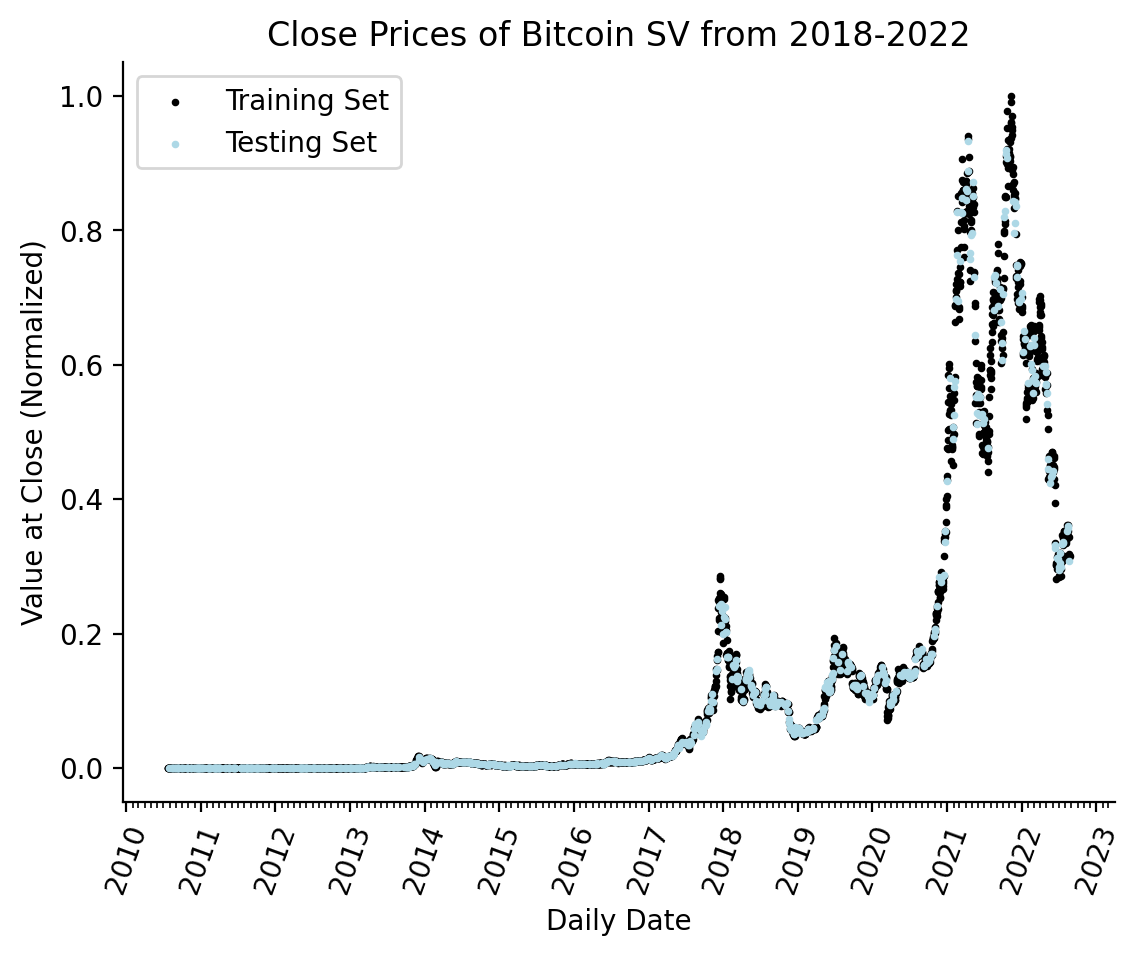

In [10]:
# Plotting our test and training sets
fig, ax = plt.subplots()

# Formatting commands for plotting month/day/year data:
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 1)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())


ax.scatter(train_DF['Date'], train_DF['Training Set'], s = 3, color = 'k', label = "Training Set")
ax.scatter(test_DF['Date'], test_DF['Testing Set'], s = 3, color = 'lightblue', label = "Testing Set")

ax.set_ylabel('Value at Close (Normalized)');
ax.set_xlabel('Daily Date');
ax.set_title('Close Prices of Bitcoin SV from 2018-2022')
ax.legend(frameon = True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', rotation=70)

plt.savefig(PATH + 'model_images/TrainTest_SetExample.png', dpi = 150)

# Training Function

In [11]:
def train_test_loss(net, criterion, optimizer, train_loader, test_loader, 
                    num_epochs=1, verbose=True, training_plot=False, device='mps'):
    """
    Accumulate training loss/Evaluate performance
    
    Args:
    net: instance of our MLP network
    criterion: torch.nn type
      Our loss function. Here we are using mean-squared-error (MSE)
    optimizer: torch.optim type
    train_loader: torch.utils.data type
      Provides an iterable over the given training set (both predictors and ground truth value)
    test_loader: torch.utils.data type
      Provides an iterable over the given training set (both predictors and ground truth value)
    num_epochs: int
      Number of epochs
    verbose: boolean
      If True, print statistics
    training_plot=False
      If True, display training plot
    device: string
      MPS/GPU (apple silicon) if available, CPU otherwise
    
    Returns:
    training error: float
        MSE of each epoch
    testing error: float
        MSE of each epoch on our test set"""

    # Initializing our loss holders:
    training_losses_epoch = []
    testing_losses_epoch = []
    
    # Running through n epochs of training
    for epoch in tqdm(range(num_epochs)):
        # Putting our network into training mode
        net.train()
        training_loss = 0 # total MSE over the entire dataset
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Loading our training data onto the GPU
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass of our data
            outputs = model(inputs)
            
            # Calculating our loss
            loss = criterion(torch.squeeze(outputs), targets)
            
            
            # Save loss from each epoch (training and testing)
            training_loss += loss.item()
            
            # Backpropagation
            loss.backward()
            
            # Gradient descent
            optimizer.step()
    
        # Getting our test loss for the epoch
        model.eval() # Does not locally stop gradient computation, but will turn off dropout layers if used
        test_loss = 0
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Running our model
            outputs = model(inputs)
            
            # Getting our test loss
            test_loss += criterion(torch.squeeze(outputs), targets).item()

        training_losses_epoch += [training_loss]
        testing_losses_epoch += [test_loss]

    return training_losses_epoch, testing_losses_epoch

# Running our Model

In [107]:
#-- Hyperparameters --#

# Training parameters:
num_epochs = 10
learning_rate = 0.001
batch_size = 50
max_params = 10000

# Model Architecture
input_dim = num_lags
no_hidden_layers = 5
hidden_dims = np.ones(no_hidden_layers, dtype = int)
num_layers = len(hidden_dims)
output_dim = 1

## Building our hidden dimensions with parameter ceiling ##

# Initialize parameter count
model_param_counter = Net(nn.ReLU(), input_dim, hidden_dims, output_dim).to(DEVICE)
par_count = sum(p.numel() for p in model_param_counter.parameters() if p.requires_grad)

while par_count < max_params:
      hidden_dims += 1
      model_param_counter = Net(nn.ReLU(), input_dim, hidden_dims, output_dim).to(DEVICE)
      par_count =  sum(p.numel() for p in model_param_counter.parameters() if p.requires_grad)




#-- Defining our model and loss function --#
model = Net(nn.ReLU(), input_dim, hidden_dims, output_dim).to(DEVICE)
criterion = nn.MSELoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("-------MODEL ARCHITECTURE-------")
print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total parameters: ", pytorch_total_params)

-------MODEL ARCHITECTURE-------
Net(
  (mlp): Sequential(
    (Linear_0): Linear(in_features=5, out_features=49, bias=True)
    (Activation_0): ReLU()
    (Linear_1): Linear(in_features=49, out_features=49, bias=True)
    (Activation_1): ReLU()
    (Linear_2): Linear(in_features=49, out_features=49, bias=True)
    (Activation_2): ReLU()
    (Linear_3): Linear(in_features=49, out_features=49, bias=True)
    (Activation_3): ReLU()
    (Linear_4): Linear(in_features=49, out_features=49, bias=True)
    (Activation_4): ReLU()
    (Output Linear): Linear(in_features=49, out_features=1, bias=True)
  )
)
Total parameters:  10144


In [108]:
# Splitting our data into train-test sets:
test_data = TensorDataset(X_test, y_test) # Putting a wrapper around our dataset tensors
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=2)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size,
                          shuffle=True, num_workers=2)

# Displaying some of our data to check for the correct shape:
dataiter = iter(train_loader)
data, pred = next(dataiter)
print("Data shape: ", data.shape)
print("Prediction shape: ", pred.shape)

Data shape:  torch.Size([50, 5])
Prediction shape:  torch.Size([50])


In [109]:
train_losses, test_losses = train_test_loss(model, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs, device=DEVICE)

  0%|          | 0/10 [00:00<?, ?it/s]

Minimum Training Loss (MSE):  0.012133623926274595
Minimum Testing Loss (MSE):  0.003251296417147387


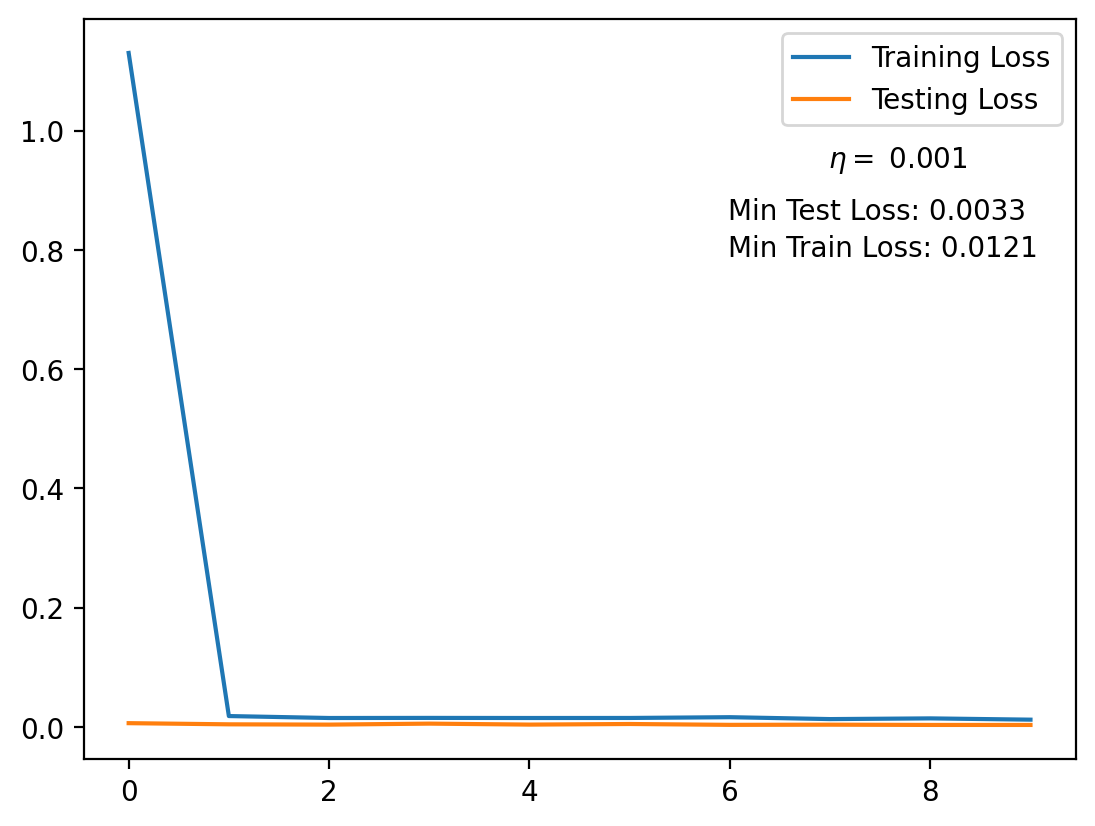

In [110]:
# Printing out some meaningful things
print("Minimum Training Loss (MSE): ", np.min(train_losses))
print("Minimum Testing Loss (MSE): ", np.min(test_losses))

# Plotting our Losses
fig, ax = plt.subplots()
ax.plot(train_losses, label = "Training Loss")
ax.plot(test_losses, label = "Testing Loss")
ax.text(0.75,0.8,f"$\eta= $ {learning_rate}", transform = ax.transAxes)
ax.text(0.65,0.73,f"Min Test Loss: {round(np.min(test_losses),4)}", transform = ax.transAxes)
ax.text(0.65, 0.68,f"Min Train Loss: {round(np.min(train_losses), 4)}", transform = ax.transAxes)
ax.legend()



plt.savefig(PATH + 'model_images/TrainTest_layer5.png', dpi = 150)

In [111]:
# Predicting each lag 0 data point:
y_pred = model(X.to(DEVICE)).cpu()
y_pred = y_pred.detach().numpy()
y_pred = y_pred[shuffled_indices]

# Test Set Predictions
y_pred_test = y_pred[:test_size]

# Training Set Predictions
y_pred_train = y_pred[test_size:]

index data (e.g. length): RangeIndex(start=0, stop=4420, step=1)


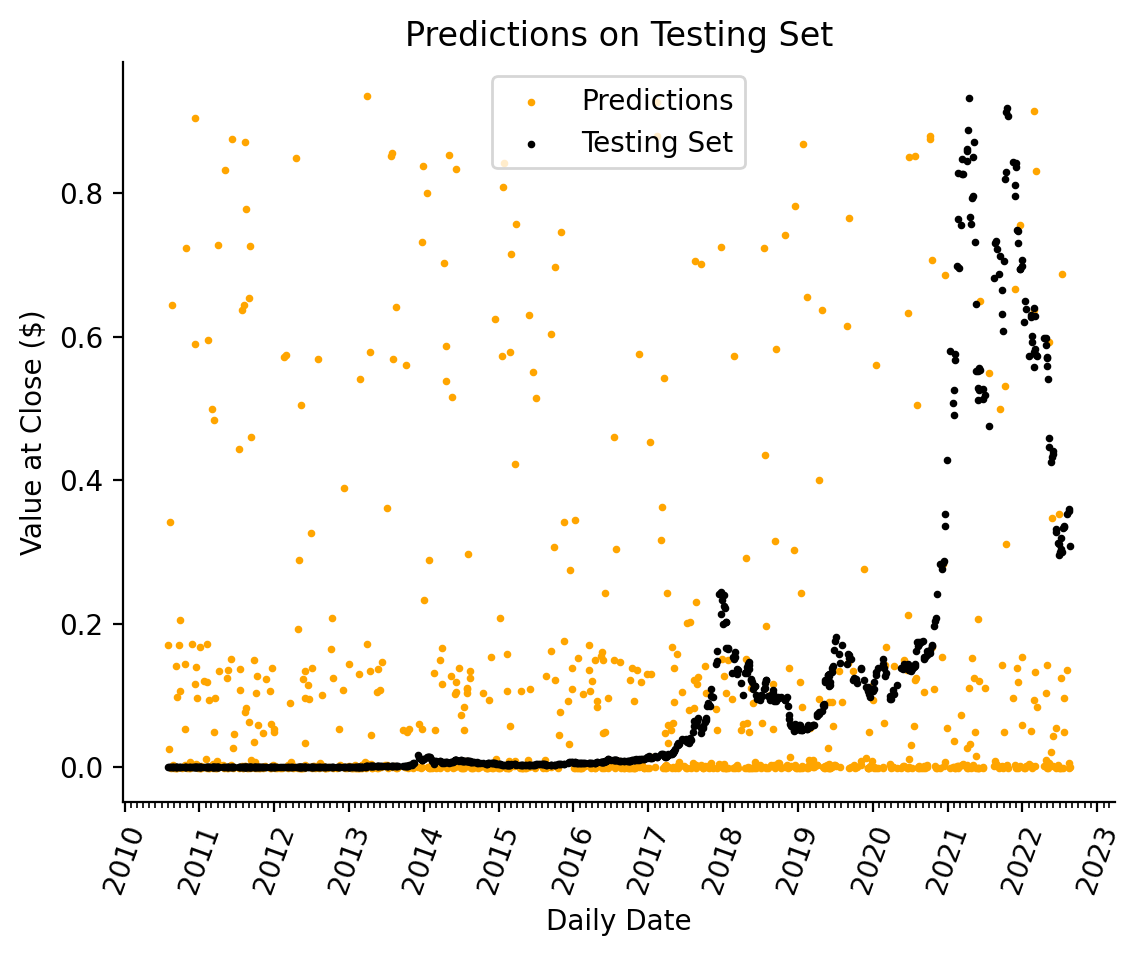

In [112]:
# Plotting our test and training sets
fig, ax = plt.subplots()

# Formatting commands for plotting month/day/year data:
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 1)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

ax.scatter(test_DF['Date'], y_pred_test[:test_size], s = 3, color = 'orange', label = "Predictions")
ax.scatter(test_DF['Date'], test_DF['Testing Set'], s = 3, color = 'k', label = "Testing Set")

ax.set_ylabel('Value at Close ($)');
ax.set_xlabel('Daily Date');
ax.set_title('Predictions on Testing Set')
ax.legend(frameon = True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print("index data (e.g. length):", BITCOIN.index)
ax.tick_params(axis='x', rotation=70)
plt.savefig(PATH + 'model_images/TestPred_layer5.png', dpi = 150)

index data (e.g. length): RangeIndex(start=0, stop=4420, step=1)


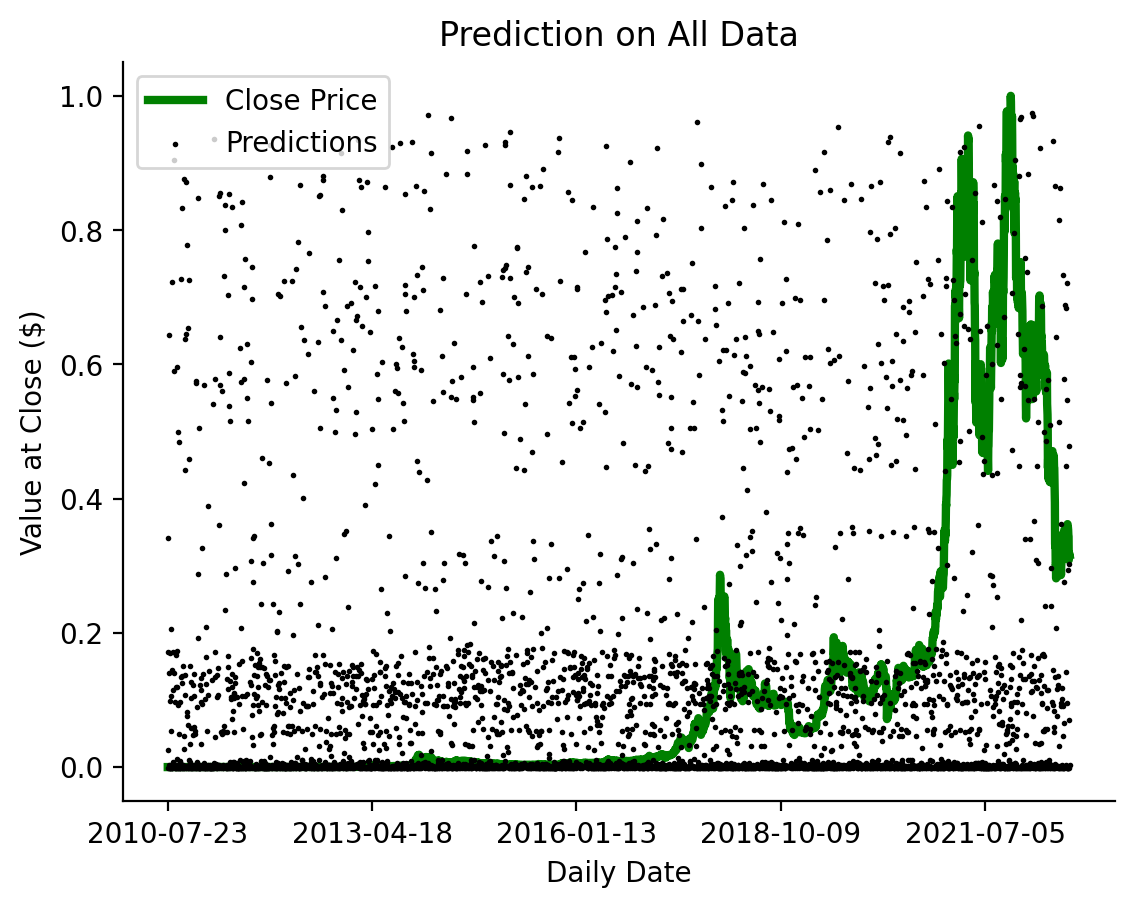

In [113]:
# Showing our predictions over our test set:
# Plotting our predictions over our actual data:
fig, ax = plt.subplots()
lag_CLOSEPRICES.plot('Date', 'Lag0', ax = ax, color = 'green', label = 'Close Price', linewidth = 3.0);
ax.scatter(dates, y_pred, color = 'k', s = 1, zorder = 2, label = 'Predictions')

ax.set_ylabel('Value at Close ($)');
ax.set_xlabel('Daily Date');
ax.set_title('Prediction on All Data')
ax.legend(frameon = True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print("index data (e.g. length):", BITCOIN.index)
plt.savefig(PATH + 'model_images/PredAll_layer5.png', dpi = 150)

# Saving and Loading our Model

In [114]:
# Saving our model
torch.save(model, PATH + "/model_layer5.pth")

In [32]:
# # Loading Code:
# model = torch.load(PATH + "/model.pth") # load model parameter
# model.eval()

In [ ]:
# 1. Save the models that were built

# Look at various different hyperparameters 
# 1. Size of the neural network (number of total parameters)
# 1.5 Activation Function
# 2. Architecture Shallow vs Moderate vs Deep: (1, 3, 5)
# 3. Learning Rate (0.01, 0.001, 0.0001)
# 4. Number of Lags (3,6,12)


# Come up with some graphs to see if you can help 





